In [1]:
import glob
import nibabel as nb
from nilearn.glm import threshold_stats_img
from nilearn import plotting
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical


/home/marilia/miniconda3/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
/home/marilia/miniconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
path = "/home/marilia/Área de Trabalho/dados_acerta/SELECTED_FILES/AMBAC_nii_stats/visit1/"
niiAMBACFiles = []
niiAMBACImages = []
for file in glob.glob(path + "*.nii"):
    niiAMBACFiles.append(file)
    img = nb.load(file)
    niiAMBACImages.append(img)

In [3]:
novo_train =  niiAMBACImages[0].slicer[:,:,:,:,1].get_fdata()
for subject in niiAMBACImages[1:]:
    # print(subject.slicer[:,:,:,:,0].shape)
    novo_train = np.append(novo_train, subject.slicer[:,:,:,:,1].get_fdata(), axis=-1)

In [4]:
novo_train.shape

(64, 76, 64, 28)

In [5]:

(xtrain, train_target), (_, _) = tf.keras.datasets.mnist.load_data()

xtrain = novo_train
# xtrain = novo_train
train_target = train_target[0:28]

# xtrain = resize(xtrain)

# xtrain = np.expand_dims(xtrain, axis=-1)
# xtrain = np.repeat(xtrain, 3, axis=-1)
# xtrain = xtrain.astype('float32') / 255
print(xtrain.shape)

# 10 categories, one for each digit
ytrain1 = tf.keras.utils.to_categorical(train_target, num_classes=10)

# 2 categories, if the digit is odd or not
ytrain2 = tf.keras.utils.to_categorical((train_target % 2 == 0).astype(int), 
                                        num_classes=2)

# 4 categories, based on the interval of the digit
ytrain3 = tf.keras.utils.to_categorical(np.digitize(train_target, [3, 6, 8]), 
                                        num_classes=4)

(64, 76, 64, 28)


In [6]:
xtrain = np.rollaxis(xtrain,3,0 )
print(xtrain.shape)

(28, 64, 76, 64)


In [7]:
xtrain = np.expand_dims(xtrain, axis=-1)

In [8]:
# # declare input shape 
# input = tf.keras.Input(shape=(64, 76, 64, 1))
# # Block 1
# base_model = tf.keras.applications.VGG16(include_top = False, weights='imagenet',  input_tensor=input)

# x = base_model.output
# # Now that we apply global max pooling.
# gap = tf.keras.layers.GlobalMaxPooling2D()(x)

# # Finally, we add a classification layer.
# last_dense1 = tf.keras.layers.Dense(10, activation='softmax', name='10Class')(gap)
# last_dense2 = tf.keras.layers.Dense(2, activation='softmax', name='2Class')(gap)
# last_dense3 = tf.keras.layers.Dense(4, activation='softmax', name='4Class')(gap)

# # bind all
# func_model = tf.keras.Model(input, [last_dense1, last_dense2, last_dense3], name="teste")

# # compile and fit (to get some optimized weight)
# func_model.compile(
#    optimizer = tf.keras.optimizers.Adam(),

#    loss = {'10Class' : 'categorical_crossentropy', 
#             '2Class' : 'categorical_crossentropy', 
#              '4Class': 'categorical_crossentropy'},
#    metrics={'10Class' : 'accuracy', 
#             '2Class' : 'accuracy', 
#             '4Class': 'accuracy'}
#     )

# func_model.fit(xtrain, [ytrain1, ytrain2,  ytrain3], 
#                epochs=5)

In [11]:
# Create the model
# sample_shape = (64, 74, 64, 1)

input_shape =(64, 76, 64,1)
# x = tf.random.normal(input_shape)
xInput = tf.keras.Input(input_shape)
# The inputs are 28x28x28 volumes with a single channel, and the
# batch size is 4

y = tf.keras.layers.Conv3D(2, 3, activation='relu', input_shape=input_shape, data_format='channels_last')(xInput)

# _conv = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(y)

# _conv = tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform')(_conv)

gap = tf.keras.layers.MaxPooling3D(pool_size=(3,3,3))(y)

gap = Flatten()(gap)

# Finally, we add a classification layer.
last_dense1 = tf.keras.layers.Dense(10, activation='softmax', name='10Class')(gap)
last_dense2 = tf.keras.layers.Dense(2, activation='softmax', name='2Class')(gap)
last_dense3 = tf.keras.layers.Dense(4, activation='softmax', name='4Class')(gap)

# bind all
func_model = tf.keras.Model(xInput, [last_dense1, last_dense2, last_dense3], name="teste")

# compile and fit (to get some optimized weight)
func_model.compile(
   optimizer = tf.keras.optimizers.Adam(),

   loss = {'10Class' : 'categorical_crossentropy', 
            '2Class' : 'categorical_crossentropy', 
             '4Class': 'categorical_crossentropy'},
   metrics={'10Class' : 'accuracy', 
            '2Class' : 'accuracy', 
            '4Class': 'accuracy'}
    )

func_model.fit(xtrain, [ytrain1, ytrain2,  ytrain3], 
               epochs=5)


# model.add(BatchNormalization(center=True, scale=True))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dense(10, activation='softmax'))

# # Compile the model
# model.compile(loss='categorical_crossentropy',
#               optimizer=keras.optimizers.Adam(lr=0.001),
#               metrics=['accuracy'])
# model.summary()
# # Fit data to model
# history = model.fit(xtrain, train_target,
#             batch_size=128,
#             epochs=40,
#             verbose=1,
#             validation_split=0.3)

Epoch 1/5
1/1 [==============================] - 9s 9s/step - loss: 7.5643 - 10Class_loss: 3.3443 - 2Class_loss: 1.0009 - 4Class_loss: 3.2191 - 10Class_accuracy: 0.1429 - 2Class_accuracy: 0.5357 - 4Class_accuracy: 0.1786
Epoch 2/5
1/1 [==============================] - 7s 7s/step - loss: 24.4844 - 10Class_loss: 9.0190 - 2Class_loss: 10.6109 - 4Class_loss: 4.8545 - 10Class_accuracy: 0.2143 - 2Class_accuracy: 0.5714 - 4Class_accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 7s 7s/step - loss: 28.8511 - 10Class_loss: 12.2520 - 2Class_loss: 5.9270 - 4Class_loss: 10.6720 - 10Class_accuracy: 0.1786 - 2Class_accuracy: 0.5714 - 4Class_accuracy: 0.3929
Epoch 4/5
1/1 [==============================] - 7s 7s/step - loss: 18.5029 - 10Class_loss: 6.4476 - 2Class_loss: 0.3667 - 4Class_loss: 11.6886 - 10Class_accuracy: 0.3571 - 2Class_accuracy: 0.8571 - 4Class_accuracy: 0.1786
Epoch 5/5
1/1 [==============================] - 8s 8s/step - loss: 14.7347 - 10Class_loss: 4.2528 - 2Class_l

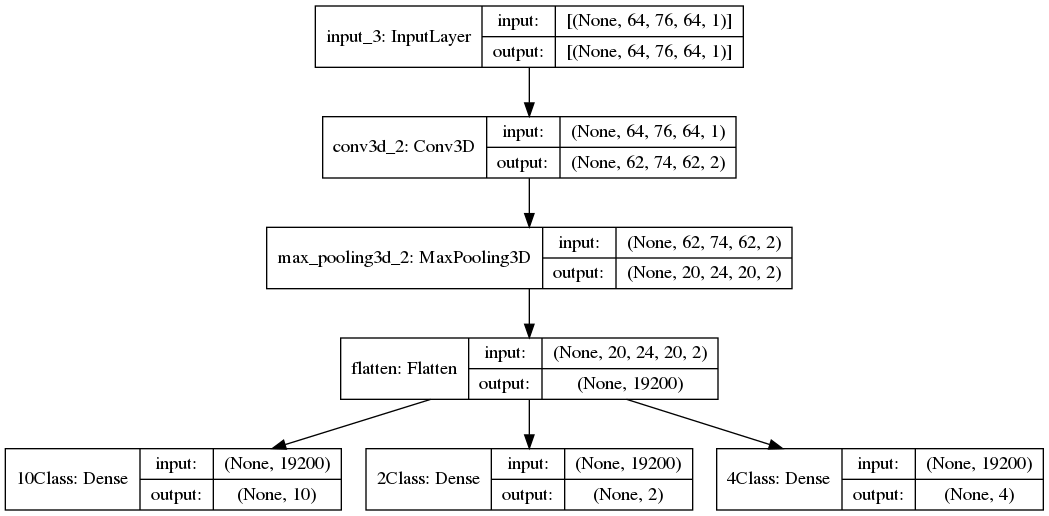

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(func_model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [33]:
last_conv = func_model.layers[0]  # block5_conv2

last_dense1 = func_model.layers[-3] # 10 classifier
last_dense2 = func_model.layers[-2] #  2 classifier 
last_dense3 = func_model.layers[-1] #  4 classifier

last_dense1_weights = last_dense1.get_weights()[0]
last_dense2_weights = last_dense2.get_weights()[0]
last_dense3_weights = last_dense3.get_weights()[0]
dense_layer_weights_list = [last_dense1_weights,
                            last_dense2_weights, 
                            last_dense3_weights]



model_cam = tf.keras.Model(inputs = xInput,
                           outputs = (last_conv.output,
                                      last_dense1.output,
                                      last_dense2.output,
                                      last_dense3.output),
                           name = 'CAM_model')

In [32]:
print(func_model.layers)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f307f941970>, <tensorflow.python.keras.layers.convolutional.Conv3D object at 0x7f307f9418b0>, <tensorflow.python.keras.layers.pooling.MaxPooling3D object at 0x7f305c484760>, <tensorflow.python.keras.layers.core.Flatten object at 0x7f307f941880>, <tensorflow.python.keras.layers.core.Dense object at 0x7f305c484790>, <tensorflow.python.keras.layers.core.Dense object at 0x7f305c395610>, <tensorflow.python.keras.layers.core.Dense object at 0x7f305c395250>]


In [53]:
model_cam.predict(xtrain, verbose=False)

   [0., 0.],
           ...,
           [0., 0.],
           [0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.],
           [0., 0.],
           ...,
           [0., 0.],
           [0., 0.],
           [0., 0.]],
 
          ...,
 
          [[0., 0.],
           [0., 0.],
           [0., 0.],
           ...,
           [0., 0.],
           [0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.],
           [0., 0.],
           ...,
           [0., 0.],
           [0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.],
           [0., 0.],
           ...,
           [0., 0.],
           [0., 0.],
           [0., 0.]]]],
 
 
 
        [[[[0., 0.],
           [0., 0.],
           [0., 0.],
           ...,
           [0., 0.],
           [0., 0.],
           [0., 0.]],
 
          [[0., 0.],
           [0., 0.],
           [0., 0.],
           ...,
           [0., 0.],
           [0., 0.],
           [0., 0.]],
 
          [[

In [35]:
features, preds1, preds2, preds3 = model_cam.predict(xtrain)

print(f'{features.shape}')
print(f'{preds1.shape}')
print(f'{preds2.shape}')
print(f'{preds3.shape}')

# (60000, 2, 2, 512)
# (60000, 10)
# (60000, 2)
# (60000, 4)

(28, 62, 74, 62, 2)
(28, 10)
(28, 2)
(28, 4)


In [36]:
raw_preds_list = [preds1, preds2, preds3]

In [48]:
features.shape

(28, 62, 74, 62, 2)

In [55]:
import scipy
import matplotlib.pyplot as plt 

ImgSize  = 32 # Image dimention 
FeatMaps = 17 # No of feature maps

def showing_cam(img, 
                img_arrays, 
                features=features, 
                raw_preds_list=raw_preds_list, 
                dense_layer_weights_list=dense_layer_weights_list):
    
    features_for_img = features[img,:,:,:,1]
    
    root_preds = np.argmax(raw_preds_list[0][img])
    print(root_preds)
    vowel_preds = np.argmax(raw_preds_list[1][img])
    consonant_preds = np.argmax(raw_preds_list[2][img])
    predicted_img_list = [root_preds, vowel_preds, consonant_preds]
    
    preds_root_round = np.round(raw_preds_list[0][img][root_preds], 3)
    preds_vowel_round = np.round(raw_preds_list[1][img][vowel_preds], 3)
    preds_consonant_round = np.round(raw_preds_list[2][img][consonant_preds], 3)
    
    # Upscaling those features to the size of the image:
    scale_factor_height = ImgSize/features[FeatMaps,:,:,:].shape[0]
    scale_factor_width = ImgSize/features[FeatMaps,:,:,:].shape[1]
    
    upscaled_features = scipy.ndimage.zoom(features[img,:,:,:,1], 
                                           (scale_factor_height, scale_factor_width, 1), 
                                           order=1)
    
    prediction_for_img = []
    cam_weights = []
    cam_output = []
    
    for symbol in range(3):
        prediction_for_img.append(predicted_img_list[symbol])
        cam_weights.append(dense_layer_weights_list[symbol][:,prediction_for_img[symbol]])
        print(dense_layer_weights_list[symbol][:,prediction_for_img[symbol]].shape)
        cam_output.append(np.dot(upscaled_features, cam_weights[symbol]))
    
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(15, 10))
    
    squeezed_img = np.squeeze(img_arrays[img]) #, axis=0)
    
    ax0.imshow(squeezed_img, cmap='Greys')
    ax0.set_title("Original image")
    
    ax1.imshow(squeezed_img, cmap='Greys', alpha=0.5)
    ax1.imshow(cam_output[0], cmap='jet', alpha=0.5)
    ax1.set_title('CAM_10 {} w/prob {:.2f}'.format(root_preds,preds_root_round ))
    
    ax2.imshow(squeezed_img, cmap='Greys', alpha=0.5)
    ax2.imshow(cam_output[1], cmap='jet', alpha=0.5)
    ax2.set_title('CAM_2 {} w/prob {:.2f}'.format(vowel_preds,preds_vowel_round ))

    ax3.imshow(squeezed_img, cmap='Greys', alpha=0.5)
    ax3.imshow(cam_output[2], cmap='jet', alpha=0.5)
    ax3.set_title('CAM_4 {} w/prob {:.2f}'.format(consonant_preds,preds_consonant_round ))
    plt.show()

In [56]:
for img in range(10,15):
    showing_cam(img, img_arrays=xtrain)

4
(19200,)


ValueError: shapes (32,32,62) and (19200,) not aligned: 62 (dim 2) != 19200 (dim 0)

In [52]:
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)
# resize the resulting heatmap to the original input image dimensions
# and then overlay heatmap on top of the image
heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

# draw the predicted label on the output image
cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, label, (10, 25), cv2.FONT_HERSHEY_SIMPLEX,
	0.8, (255, 255, 255), 2)
# display the original image and resulting heatmap and output image
# to our screen
output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2.imshow("Output", output)
cv2.waitKey(0)

(28, 64, 76, 64, 1)